In [1]:
import kagglehub
import shutil
import os

# Step 1: Download dataset (downloads to ~/.kagglehub)
dataset_path = kagglehub.dataset_download('hugomathien/soccer')

# Step 2: Define your flat target folder (e.g., 'data')
target_path = 'data'

# Step 3: Copy all files (flat) into the target folder
if not os.path.exists(target_path):
    os.makedirs(target_path)

for filename in os.listdir(dataset_path):
    src_file = os.path.join(dataset_path, filename)
    dst_file = os.path.join(target_path, filename)

    if os.path.isfile(src_file):  # ignore folders
        shutil.copy2(src_file, dst_file)

print(f"All dataset files copied to: {target_path}")


/home/robin/Code/Uni/MetaLabelingSportsPrediction/MetaLabelingSportsPrediction/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All dataset files copied to: data


In [2]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
import warnings

warnings.simplefilter("ignore")

In [3]:
## Loading all functions
def get_match_label(match):
    ''' Derives a label for a given match. '''

    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']

    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id']

    #Identify match label
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"

    #Return label
    return label.loc[0]

import numpy as np
import pandas as pd

def get_fifa_stats(match, player_stats_lookup):
    ''' Efficiently aggregates FIFA stats for a given match. '''

    match_id = match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]

    row = {}
    for player in players:
        player_id = match[player]

        if np.isnan(player_id):
            row[f"{player}_overall_rating"] = 0
            continue

        # Use pre-sorted lookup table (dict of DataFrames)
        stats = player_stats_lookup.get(player_id)
        if stats is not None:
            # Use .searchsorted for fast filtering by date
            idx = stats['date'].searchsorted(date, side='left') - 1
            if idx >= 0:
                row[f"{player}_overall_rating"] = stats.iloc[idx]['overall_rating']
            else:
                row[f"{player}_overall_rating"] = 0
        else:
            row[f"{player}_overall_rating"] = 0

    row['match_api_id'] = match_id
    return pd.Series(row)

def build_player_stats_lookup(player_stats):
    ''' Build a pre-sorted dictionary of player stats for quick access. '''
    player_stats = player_stats.sort_values(['player_api_id', 'date'])
    return {
        pid: df.reset_index(drop=True)
        for pid, df in player_stats.groupby('player_api_id')
    }


def get_fifa_data(matches, player_stats, path=None, data_exists=False):
    ''' Gets fifa data for all matches. '''

    if data_exists and path:
        return pd.read_pickle(path)

    print("Collecting FIFA data for each match...")
    player_stats_lookup = build_player_stats_lookup(player_stats)

    fifa_data = matches.apply(
        lambda row: get_fifa_stats(row, player_stats_lookup), axis=1
    )

    return fifa_data

def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''

    temp_data = fifa

    #Check if only overall player stats are desired
    if get_overall == True:

        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:

        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)
        data = temp_data

    #Return data
    return data

def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''

    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]

    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]

    #Return last matches
    return last_matches

def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''

    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]
    total_matches = pd.concat([home_matches, away_matches])

    #Get last x matches
    try:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]

        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")

    #Return data
    return last_matches

def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''

    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    #Return total wins
    return total_wins

def get_match_features(match, team_histories):
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id

    home_matches = get_recent_team_matches(team_histories, home_team, date, 10)
    away_matches = get_recent_team_matches(team_histories, away_team, date, 10)

    goals_scored_home = get_goals(home_matches, home_team)
    goals_scored_away = get_goals(away_matches, away_team)
    goals_conceded_home = get_goals_conceided(home_matches, home_team)
    goals_conceded_away = get_goals_conceided(away_matches, away_team)

    return {
        'match_api_id': match.match_api_id,
        'league_id': match.league_id,
        'home_team_goals_difference': goals_scored_home - goals_conceded_home,
        'away_team_goals_difference': goals_scored_away - goals_conceded_away,
        'games_won_home_team': get_wins(home_matches, home_team),
        'games_won_away_team': get_wins(away_matches, away_team),
        # Optional: precompute `against` matches similarly
        'games_against_won': 0,
        'games_against_lost': 0,
    }


def create_feables(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''

    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)


    if verbose == True:
        print("Generating match features...")
    start = time()

    #Get match features for all matches
    team_histories = precompute_last_matches(matches)
    print("Preindex_match_data")
    match_stats = matches.apply(lambda row: pd.Series(get_match_features(row, team_histories)), axis=1)
    print("apply {:.1f} minutes".format((time() - start)/60))
    #Create dummies for league ID feature
    dummies = pd.get_dummies(match_stats['league_id']).rename(columns = lambda x: 'League_' + str(x))
    print("dummy {:.1f} minutes".format((time() - start)/60))
    match_stats = pd.concat([match_stats, dummies], axis = 1)
    print("concat {:.1f} minutes".format((time() - start)/60))
    match_stats.drop(['league_id'], inplace = True, axis = 1)

    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))

    if verbose == True:
        print("Generating match labels...")
    start = time()

    #Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))

    if verbose == True:
        print("Generating bookkeeper data...")
    start = time()

    #Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

    #Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')

    #Drop NA values
    feables.dropna(inplace = True)

    #Return preprocessed data
    return feables

def precompute_last_matches(matches, x=10):
    matches_sorted = matches.sort_values(by='date')
    team_histories = {}

    for team in pd.concat([matches_sorted['home_team_api_id'], matches_sorted['away_team_api_id']]).unique():
        team_matches = matches_sorted[(matches['home_team_api_id'] == team) | (matches_sorted['away_team_api_id'] == team)]
        team_histories[team] = team_matches.sort_values('date').reset_index(drop=True)
    return team_histories

def get_recent_team_matches(team_histories, team_id, current_date, x):
    team_matches = team_histories.get(team_id, pd.DataFrame())
    return team_matches[team_matches['date'] < current_date].tail(x)

def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True,
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''

    #Start the clock, train the classifier, then stop the clock
    start = time()

    #Check if grid search should be applied
    if use_grid_search == True:

        #Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)

        #Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:

        #Use best components that are known without grid search
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)
        best_pipe = pipeline.fit(X_train, y_train)

    end = time()

    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))

    #Return best pipe
    return best_pipe

def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''

    #Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()

    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)

def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs,
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''

    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))

    #Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)

    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))

    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))

    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)

def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''

    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']

    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd

    total_prob = win_prob + draw_prob + loss_prob

    probs = pd.DataFrame()

    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob

    #Return probs and meta data
    return probs

def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''

    bk_data = pd.DataFrame()

    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']

        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Defeat']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Defeat'] = pd.to_numeric(temp_data['Defeat'])

        #Check if data should be aggregated horizontally
        if(horizontal == True):

            #Convert data to probs
            #temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)

            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            defeat_name = bookkeeper + "_" + "Defeat"
            temp_data.columns.values[:3] = [win_name, draw_name, defeat_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = pd.concat([bk_data, temp_data], ignore_index=True)

    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']

    #Return bookkeeper data
    return bk_data

def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''

    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)

    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)

    #Return data
    return probs

def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels=labels)
    if normalize:
        cm = cm.astype('float') / cm.sum()

    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    # Corrected attribute name: Use .estimator instead of .base_estimator
    title = "Confusion matrix of a {} with {}".format(
    getattr(clf, 'estimator', clf).__class__.__name__,
    dim_reduce.__class__.__name__)


    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred))

def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''

    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)

    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]

    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)

    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)

    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = pd.concat([model_probs, temp_probs], ignore_index=True)
        label_table = pd.concat([label_table, labels], ignore_index=True)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table

    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})

    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})

    #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})

    total = pd.concat([wins, draws, defeats])

    #Return total
    return total

def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''

    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]

    #Sort by createst difference to identify most underestimated bets
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)

    if verbose == True:
        print("Selecting attractive bets...")

    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]

    #Select given percentile of relevant choices
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)

    #Return choices
    return choices

def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''

    #Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols

    #Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")

    #Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0

    #Return reward
    return reward

def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''

    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0

    #Loop through bets
    loops = np.arange(0, bet_choices.shape[0])
    for i in loops:

        #Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1

    #Compute investment return
    investment_return = float(total_reward / total_invested) - 1

    #Return investment return
    return investment_return

def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''

    #Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)

    #Loop through features
    i = 1
    for col in features.columns:

        #Set subplot and plot format
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1

        #Plot KDE for all labels
        sns.kdeplot(data=inputs[inputs['label'] == 'Win'].iloc[:,j], label='Win', fill=True)
        sns.kdeplot(data=inputs[inputs['label'] == 'Draw'].iloc[:,j], label='Draw', fill=True)
        sns.kdeplot(data=inputs[inputs['label'] == 'Defeat'].iloc[:,j], label='Defeat', fill=True)
        plt.legend();
        i = i + 1

    #Define plot format
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()

    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)

    #Store description of all features
    feature_details = features.describe().transpose()

    #Return feature details
    return feature_details

def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''

    #Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []

    #Loop through dimensionality reductions
    for dm in dm_reductions:

        #Loop through classifiers
        for clf in clfs:

            #Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)

            #Append the result to storage
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)

    #Return storage
    return clfs_return, dm_reduce_return, train_scores, test_scores

def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''

    #Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0.5
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []

    #Loop throuugh classifiers
    for i in range(0, len(clfs)):

        #Define temporary variables
        clf = clfs[i]
        # Access the base estimator through the 'estimator' attribute
        clf_name = clf.estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__

        #Create and store name
        name = "{} with {}".format(clf.estimator.__class__.__name__, dm.__class__.__name__)
        names.append(name)

    #Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)

    plt.show()


def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    ''' Tune parameters of bet selection algorithm. '''

    #Generate data samples
    samples = []
    for i in range(0, n_samples):
        sample = match_data.sample(n = sample_size, random_state = 42)
        samples.append(sample)

    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0

    #Iterate over all 1 parameter
    for i in parameter_1_grid:

        #Iterate over all 2 parameter
        for j in parameter_2_grid:

            #Compute average score over all samples
            profits = []
            for sample in samples:
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row,"results"] = result
            results.loc[row,"parameter_1"] = i
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))

    #Return best setting and result
    best_result = results.loc[results['results'].idxmax()]
    return best_result


def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose=False, normalize=True):
    """
    Plot confusion matrix of bookkeeper predictions.
    """
    if verbose:
        print("Obtaining labels...")

    # Get true labels
    y_test_temp = matches.apply(get_match_label, axis=1)

    if verbose:
        print("Obtaining bookkeeper probabilities...")

    # Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace=True, drop=True)
    bookkeeper_probs.dropna(inplace=True)

    if verbose:
        print("Obtaining bookkeeper labels...")

    # Get predicted labels from max-probability
    y_pred_temp = pd.DataFrame()
    y_pred_temp["bk_label"] = bookkeeper_probs[["Win", "Draw", "Defeat"]].idxmax(axis=1)
    y_pred_temp["match_api_id"] = bookkeeper_probs["match_api_id"]

    if verbose:
        print("Plotting confusion matrix...")

    # Join predictions with true labels
    results = pd.merge(y_pred_temp, y_test_temp, on="match_api_id", how="left")
    y_test = results["label"]
    y_pred = results["bk_label"]

    # Define label order
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    if normalize:
        cm = cm.astype("float") / cm.sum()

    # Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid": False})
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix of Bookkeeper predictions")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    # Print report and accuracy
    print(classification_report(y_test, y_pred))
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))


In [4]:

path = "data/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)

#Reduce match data to fulfill run time requirements
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id",
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7",
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)

Generating match features...
Preindex_match_data
apply 1.0 minutes
dummy 1.0 minutes
concat 1.0 minutes
Match features generated in 1.0 minutes
Generating match labels...
Match labels generated in 0.3 minutes
Generating bookkeeper data...
Bookkeeper data generated in 0.0 minutes


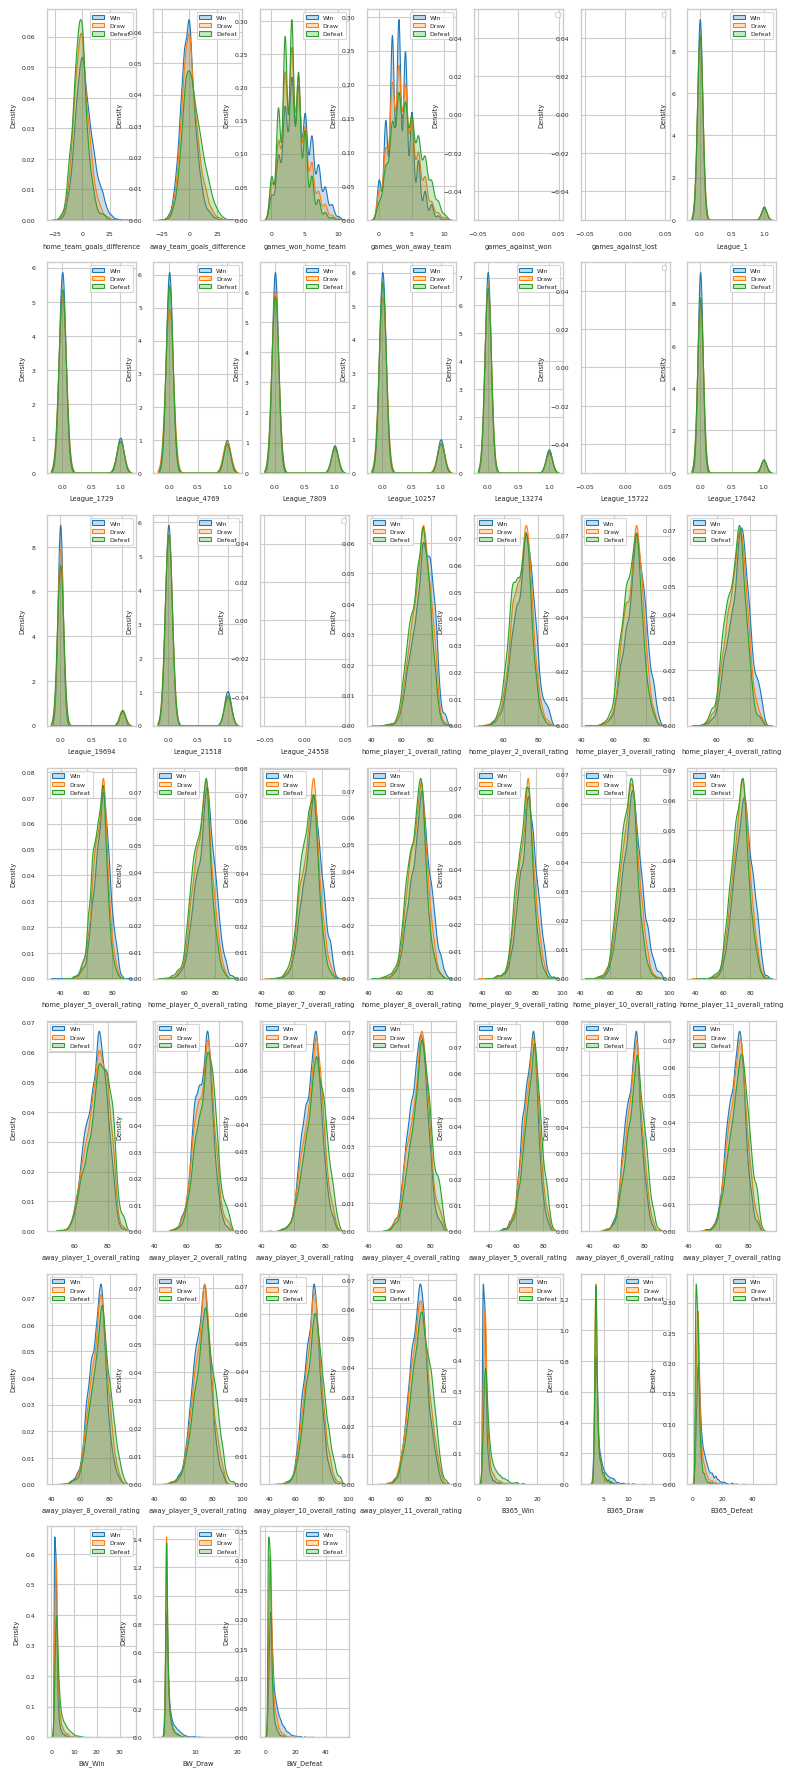

label
Win       0.459317
Defeat    0.288216
Draw      0.252467
Name: count, dtype: float64


5

In [5]:
## Generating features, exploring the data, and preparing data for model training
#Generating or retrieving already existant FIFA data
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

#Creating features and labels based on data provided
bk_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bk_cols_selected = ['B365', 'BW']
feables = create_feables(match_data, fifa_data, bk_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)
feature_details = explore_data(features, inputs, path)

#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42,
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42,
                                                              stratify = y_train_calibrate)

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

In [6]:
## Initializing all models and parameters
#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB_clf = GaussianNB()
KNN_clf =  KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced', random_state = 189)
clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'],
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5),
                 'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_GNB = {'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_KNN = {'clf__n_neighbors': [3, 5, 10],
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5),
                  'dm_reduce__n_components': np.arange(5, feature_len, np.around(feature_len/5)).astype(int)} # Cast to int


parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_GNB,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG}

#Initializing dimensionality reductions
pca = PCA()
dm_reductions = [pca]

## Train a Logistic Regression Model as Primary Model

In [ ]:
from sklearn.model_selection import GridSearchCV

## Training a baseline model and finding the best model composition using grid search
#Train a simple GBC classifier as baseline model
clf = LOG_clf
clf.fit(X_train, y_train)

# Define a grid of hyperparameters for Logistic Regression
param_grid = {
    'C': [100],
    'solver': ['liblinear'],
    'class_weight': [None],
    'multi_class': ['ovr']
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=189, max_iter=100),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=n_jobs,
    verbose=1
)

# Fit grid search on training data
grid_search.fit(X_train, y_train)

# Use the best estimator found
clf = grid_search.best_estimator_
print("Best Logistic Regression parameters:", grid_search.best_params_)


y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, y_pred_train)))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, y_pred_test)))

##### Blog for Meta Labeling

# Store meta labels (1 if correct, 0 if incorrect)
meta_labels_train = (y_pred_train == y_train).astype(int)
meta_labels_test = (y_pred_test == y_test).astype(int)

# get Meta Features
meta_features_train = clf.predict_proba(X_train)
meta_features_test = clf.predict_proba(X_test)
#######1




Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best Logistic Regression parameters: {'C': 100, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'liblinear'}
Score of LogisticRegression for training set: 0.5324.
Score of LogisticRegression for test set: 0.5243.


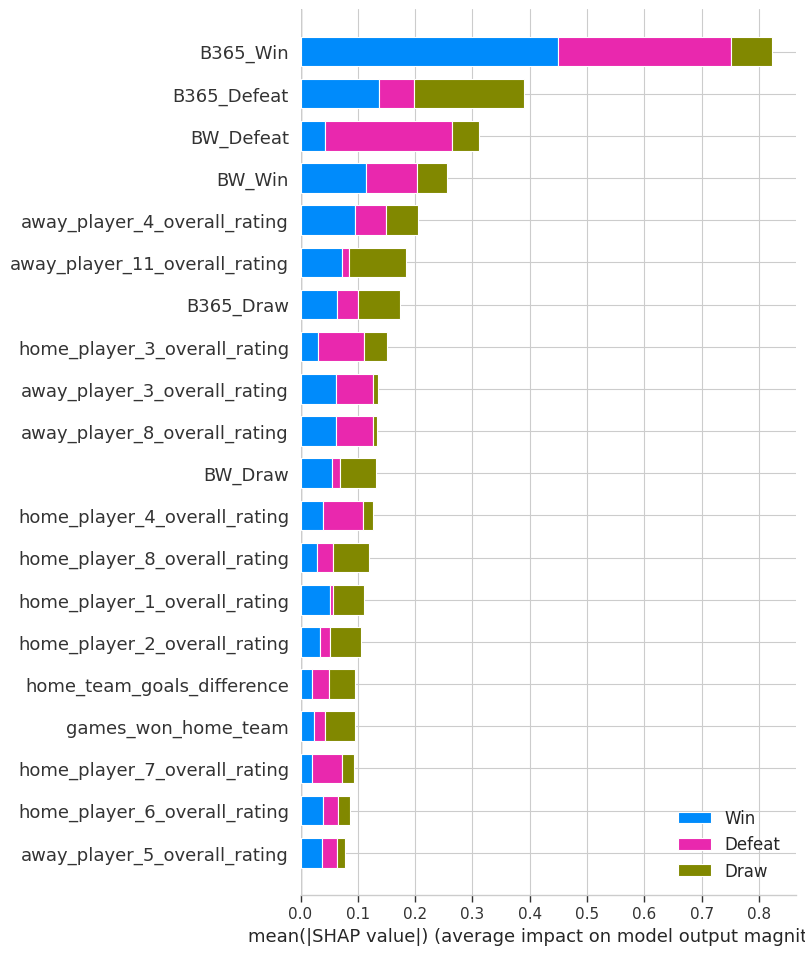

In [51]:
import shap

explainer = shap.Explainer(clf, X_train.astype(float))

shap_values = explainer(X_test.astype(float))

shap.summary_plot(shap_values, X_test, plot_type="bar", class_names=['Defeat', 'Draw', 'Win'])

## SHAPs for each Class

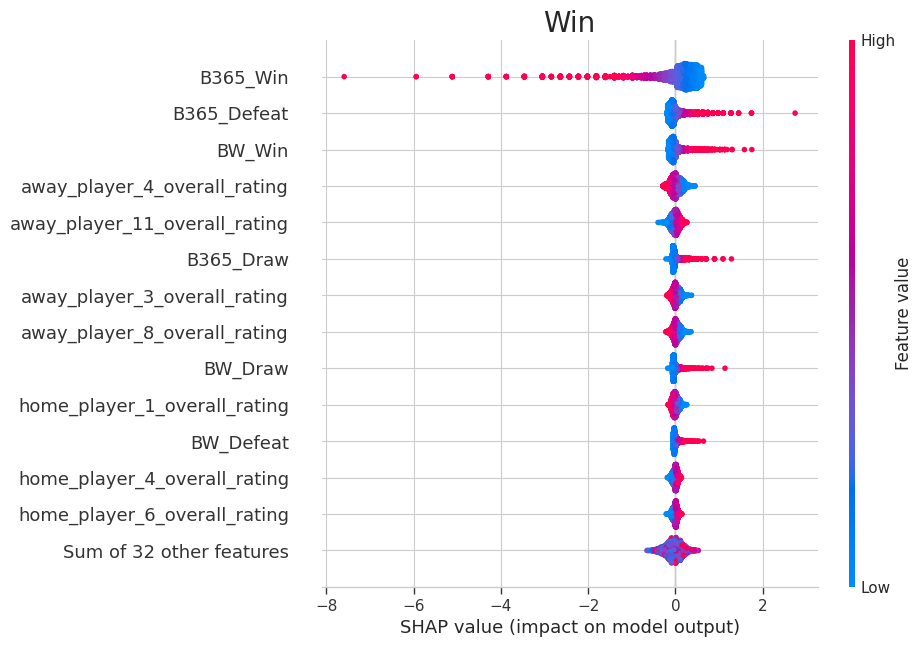

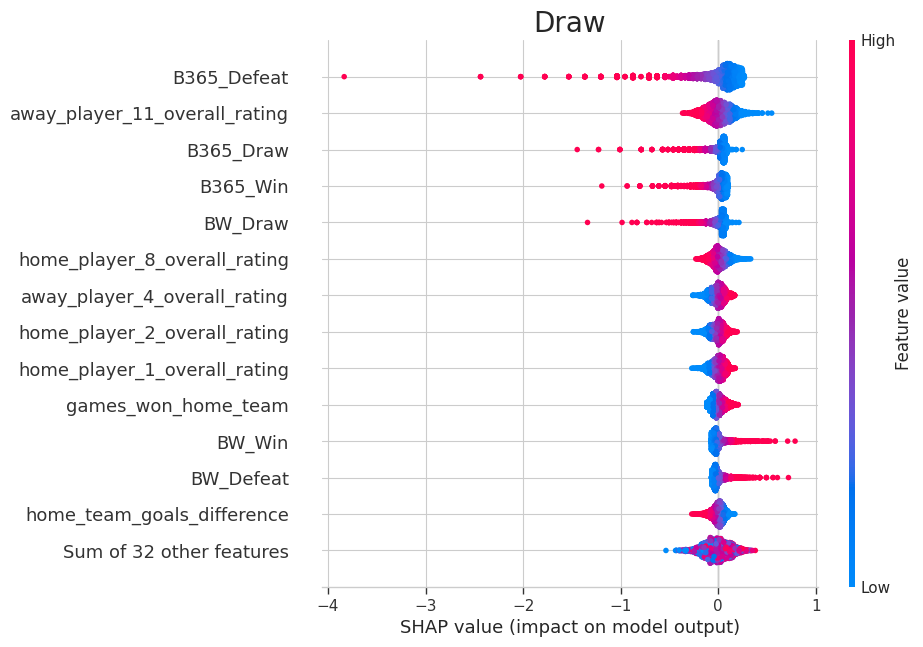

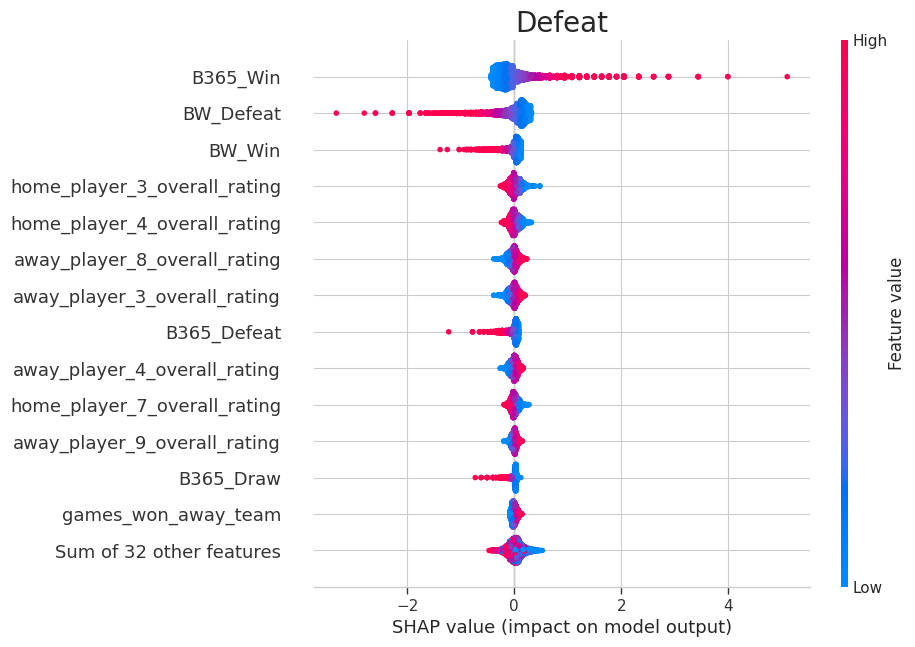

In [76]:
shap.plots.beeswarm(shap_values[:,:,2], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Win", fontsize=20)
plt.show()
shap.plots.beeswarm(shap_values[:,:,1], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Draw", fontsize=20)
plt.show()
shap.plots.beeswarm(shap_values[:,:,0], max_display=14, show=False)
ax = plt.gca()
ax.set_title("Defeat", fontsize=20)
plt.show()

In [78]:
# Step 6: Wettstrategie auswerten
df_bets = X_test.copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = y_pred_test
df_bets["actual_outcome"] = y_test

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain = df_bets["money"].sum()
avg_gain = df_bets["money"].mean()
num_bets = len(df_bets)

print(f"\n💰 Gesamtgewinn: {total_gain:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets}")



💰 Gesamtgewinn: -179.64 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.046 EUR
🎲 Anzahl getätigter Wetten: 3872


# Meta Labeling

## Find best params for Logistic Regression Model as Secondary Model

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


# Step 1: Convert meta features (probas) to DataFrame
meta_features_df = pd.DataFrame(meta_features_train, columns=['proba_win', 'proba_draw', 'proba_defeat'])

# Step 2: Reset index of X_train to ensure alignment
X_train_reset = X_train.reset_index(drop=True)
meta_features_df = meta_features_df.reset_index(drop=True)

# Step 3: Concatenate base features with meta features
X_meta_train = pd.concat([X_train_reset, meta_features_df], axis=1)

# Step 4: Use the meta_labels as target for the meta-model
y_meta_train = meta_labels_train

# Define hyperparameter grid for LogisticRegression
meta_param_grid = {
    'C': [100],
    'solver': ['liblinear'],
    'class_weight': ['balanced'],
    'max_iter': [100]
}

# Set up GridSearchCV for the meta-model
meta_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=meta_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=n_jobs,
    verbose=1
)

# Fit grid search on meta training data
meta_grid_search.fit(X_meta_train, y_meta_train)

# Use the best estimator found
meta_clf_Logistic = meta_grid_search.best_estimator_
print("Best meta-model parameters:", meta_grid_search.best_params_)
print("Best cross-validation accuracy:", meta_grid_search.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best meta-model parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 100, 'solver': 'liblinear'}
Best cross-validation accuracy: 0.5887074453362856


## Train Logistic Regression Model as Secondary Model

In [91]:
# Step 5: Train the meta-model
meta_clf_Logistic.fit(X_meta_train, y_meta_train)

# Meta features from test predictions
meta_features_test_df = pd.DataFrame(meta_features_test, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_test_reset = X_test.reset_index(drop=True)
X_meta_test = pd.concat([X_test_reset, meta_features_test_df], axis=1)
y_meta_test = meta_labels_test

# Evaluate
y_meta_pred = meta_clf_Logistic.predict(X_meta_test)

print("Meta model accuracy on predicting if primary model is correct:", accuracy_score(y_meta_test, y_meta_pred))

final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)

# Find indices where final_prediction is not 0
nonzero_indices = np.where(final_prediction != 0)[0]

# Get the corresponding predictions and true labels
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

# Calculate accuracy for these predictions
correct = (preds == true_labels).sum()
total = len(nonzero_indices)
percentage_correct = correct / total if total > 0 else 0

print(f"Correct predicts on bets: {percentage_correct:.4f} ({correct}/{total})")

# Step 6: Wettstrategie auswerten
df_bets = X_meta_test.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain = df_bets["money"].sum()
avg_gain = df_bets["money"].mean()
num_bets = len(df_bets)

print(f"\n💰 Gesamtgewinn: {total_gain:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets}")


Meta model accuracy on predicting if primary model is correct: 0.5989152892561983
Correct predicts on bets: 0.6795 (903/1329)

💰 Gesamtgewinn: -43.34 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.033 EUR
🎲 Anzahl getätigter Wetten: 1329


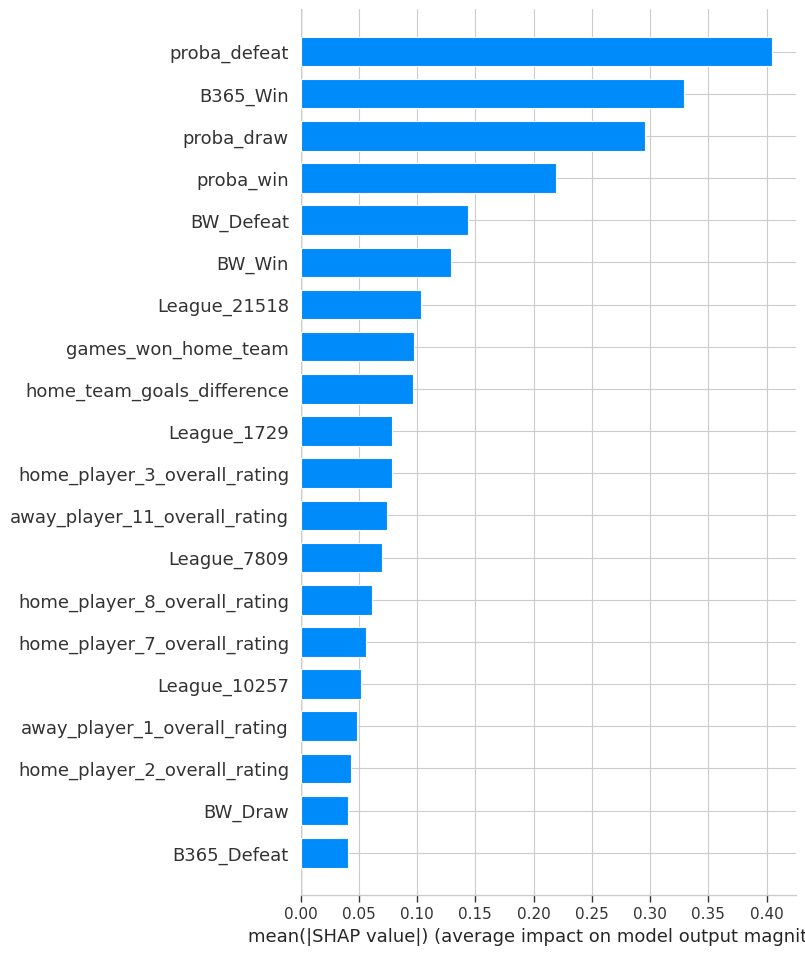

In [ ]:
import shap

explainer = shap.Explainer(meta_clf_Logistic, X_meta_train.astype(float))

shap_values = explainer(X_meta_test.iloc[nonzero_indices].astype(float))

shap.plots.beeswarm(shap_values, max_display=14, show=False)
ax = plt.gca()
ax.set_title("Linear Regression", fontsize=20)
plt.show()

## Find best params for LGBM Classifier as Secondary Model

In [99]:
import pandas as pd
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform as sp_uniform # For defining distributions

# Assuming clf, X_train, y_train, X_test, y_test, y_pred_test are already defined
# and clf is your primary model that can call .predict_proba()

# --- Prepare Meta Features and Labels (same as before) ---
meta_features_df = pd.DataFrame(meta_features_train, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_train_reset = X_train.reset_index(drop=True)
meta_features_df = meta_features_df.reset_index(drop=True)
X_meta_train = pd.concat([X_train_reset, meta_features_df], axis=1)
y_meta_train = meta_labels_train

# --- Hyperparameter Search for LGBMClassifier ---

# Define the parameter distribution for RandomizedSearchCV
# This is a sample, you might want to adjust the ranges and add more parameters
param_dist = {
    'n_estimators': [300],             # Static: Number of boosting rounds
    'learning_rate': [0.01],          # Static: Step size shrinkage
    'num_leaves': [31],                  # Static: Max number of leaves in one tree
    'max_depth': [10],                    # Static: Max tree depth (-1 means no limit)
    'min_child_samples': [10, 20, 50],           # Static: Minimum number of data in a leaf
    'subsample': [0.8],          # Static: Subsample ratio of the training instance
    'colsample_bytree': [0.7],         # Static: Subsample ratio of columns when constructing each tree
    'reg_alpha': [0.1],               # Static: L1 regularization
    'reg_lambda': [0.01],
    'device' : ['cpu']
}

# Initialize LGBMClassifier with some base parameters
lgbm = LGBMClassifier(objective='binary', random_state=42, n_jobs=1, verbose=1) # Use n_jobs=-1 for all cores

# Set up RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled. Trade-off between runtime and quality of the solution.
# cv: Number of cross-validation folds.
# scoring: Metric to optimize (e.g., 'accuracy', 'roc_auc', 'f1').
# verbose: Controls the verbosity of the output.
# random_state: For reproducibility.
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,  # You can increase this for a more thorough search
    cv=3,       # 5-fold cross-validation
    scoring='accuracy', # Or 'roc_auc' if you care about probabilities more
    verbose=0,
    random_state=42,
    n_jobs=1   # Use all available CPU cores for parallel processing
)

# Fit RandomizedSearchCV to find the best hyperparameters
print("Performing hyperparameter search for LGBMClassifier...")
random_search.fit(X_meta_train, y_meta_train)

# Get the best estimator (LGBMClassifier with optimized hyperparameters)
meta_clf_LGBM = random_search.best_estimator_

print("\nBest hyperparameters found:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

Performing hyperparameter search for LGBMClassifier...
[LightGBM] [Info] Number of positive: 3847, number of negative: 3379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 7226, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,532383 -> initscore=0,129714
[LightGBM] [Info] Start training from score 0,129714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 3847, number of negative: 3379
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,004832 seconds.
You can set `force_col_wise=true` to remove the overhead.


## Train LGBM Model as Secondary Model

In [100]:
# Step 1: Meta-Modell trainieren
meta_clf_LGBM.fit(X_meta_train, y_meta_train)

# Step 2: Meta-Testdaten vorbereiten
meta_features_test_df = pd.DataFrame(meta_features_test, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_test_reset = X_test.reset_index(drop=True)
X_meta_test = pd.concat([X_test_reset, meta_features_test_df], axis=1)
y_meta_test = meta_labels_test

# Step 3: Meta-Vorhersagen treffen
y_meta_pred = meta_clf_LGBM.predict(X_meta_test)
print("Meta model accuracy on predicting if primary model is correct:",
      accuracy_score(y_meta_test, y_meta_pred))

# Step 4: Finale Vorhersage – nur wenn Meta-Modell "vertraut"
final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)  # 0 = keine Wette

# Step 5: Trefferquote unter Meta-genehmigten Tipps
nonzero_indices = np.where(final_prediction != 0)[0]
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

correct = (preds == true_labels).sum()
total = len(nonzero_indices)
percentage_correct = correct / total if total > 0 else 0
print(f"Correct predicts on bets: {percentage_correct:.4f} ({correct}/{total})")

# Step 6: Wettstrategie auswerten
df_bets = X_test_reset.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain = df_bets["money"].sum()
avg_gain = df_bets["money"].mean()
num_bets = len(df_bets)

print(f"\n💰 Gesamtgewinn: {total_gain:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets}")


[LightGBM] [Info] Number of positive: 5771, number of negative: 5068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,003141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 10839, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,532429 -> initscore=0,129899
[LightGBM] [Info] Start training from score 0,129899
Meta model accuracy on predicting if primary model is correct: 0.6040805785123967
Correct predicts on bets: 0.6260 (1235/1973)

💰 Gesamtgewinn: -74.57 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.038 EUR
🎲 Anzahl getätigter Wetten: 1973


In [101]:
import shap

explainer = shap.Explainer(meta_clf_LGBM, X_meta_train.astype(float))

shap_values = explainer(X_meta_test.astype(float))

shap.summary_plot(shap_values, X_meta_test, plot_type="bar")

 93%|=================== | 3618/3872 [00:35<00:02]       

: 

: 

## Train a XGBoost as Secondary Model

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Step 1: Meta-Modell mit XGBoost trainieren
meta_clf_XGB = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
meta_clf_XGB.fit(X_meta_train, y_meta_train)

# Step 2: Meta-Testdaten vorbereiten
meta_features_test_df = pd.DataFrame(meta_features_test, columns=['proba_win', 'proba_draw', 'proba_defeat'])
X_test_reset = X_test.reset_index(drop=True)
X_meta_test = pd.concat([X_test_reset, meta_features_test_df], axis=1)
y_meta_test = meta_labels_test

# Step 3: Meta-Vorhersagen treffen
y_meta_pred = meta_clf_XGB.predict(X_meta_test)
print("Meta model accuracy on predicting if primary model is correct:",
      accuracy_score(y_meta_test, y_meta_pred))

# Step 4: Finale Vorhersage – nur wenn Meta-Modell "vertraut"
final_prediction = np.where(y_meta_pred == 1, y_pred_test, 0)  # 0 = keine Wette

# Step 5: Trefferquote unter Meta-genehmigten Tipps
nonzero_indices = np.where(final_prediction != 0)[0]
preds = final_prediction[nonzero_indices]
true_labels = y_test.reset_index(drop=True).iloc[nonzero_indices]

correct = (preds == true_labels).sum()
total = len(nonzero_indices)
percentage_correct = correct / total if total > 0 else 0
print(f"Correct predicts on bets: {percentage_correct:.4f} ({correct}/{total})")

# Step 6: Wettstrategie auswerten
df_bets = X_test_reset.iloc[nonzero_indices].copy()
df_bets["meta_pred"] = 1
df_bets["predicted_outcome"] = preds
df_bets["actual_outcome"] = true_labels

# Gewinnberechnung je Spiel
def calculate_money(row):
    if row["predicted_outcome"] == row["actual_outcome"]:
        return row["B365_" + row["actual_outcome"]] - 1  # Gewinn = Quote - Einsatz
    else:
        return -1  # Einsatz verloren

df_bets["money"] = df_bets.apply(calculate_money, axis=1)

# Gesamtauswertung
total_gain = df_bets["money"].sum()
avg_gain = df_bets["money"].mean()
num_bets = len(df_bets)

print(f"\n💰 Gesamtgewinn: {total_gain:.2f} EUR")
print(f"📊 Durchschnittlicher Gewinn pro Wette: {avg_gain:.3f} EUR")
print(f"🎲 Anzahl getätigter Wetten: {num_bets}")


Meta model accuracy on predicting if primary model is correct: 0.5720557851239669
Correct predicts on bets: 0.5931 (1188/2003)

💰 Gesamtgewinn: -83.17 EUR
📊 Durchschnittlicher Gewinn pro Wette: -0.042 EUR
🎲 Anzahl getätigter Wetten: 2003


 99%|===================| 3841/3872 [00:37<00:00]        

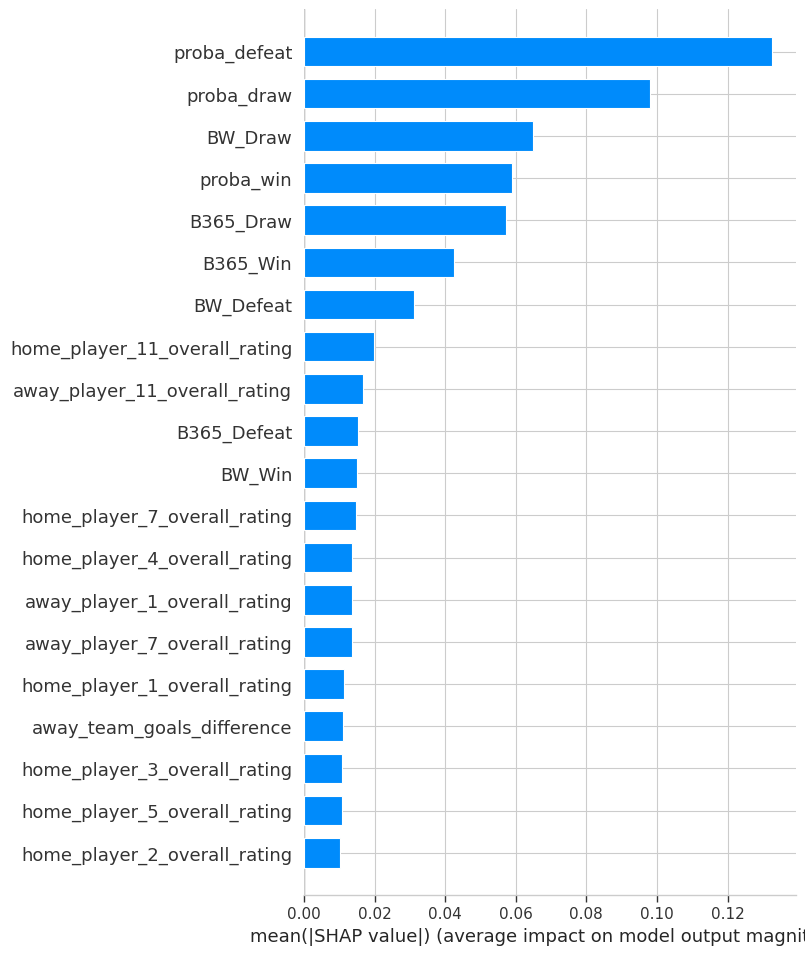

In [ ]:
import shap

explainer = shap.Explainer(meta_clf_LGBM, X_meta_train.astype(float))

shap_values = explainer(X_meta_test.astype(float))

shap.summary_plot(shap_values, X_meta_test, plot_type="bar")